In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
#from MulticoreTSNE import MulticoreTSNE as TSNE

In [78]:
wdir = "/mnt/c/Bioinf/SCENIC_fetal"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "pbmc10k_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "W20_SCENIC.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata_W20.h5ad"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output_W20.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'scenic_integrated-output_W20.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cloudpickle                 2.2.1
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.3
dask                        2022.02.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
fsspec                      2023.1.0
google                      NA
h5py                        3.8.0
igraph                      0.10.8
ipykernel                   6.15.2
ipython_genutils            0.2.0
jedi                        0.18.1
jinja2                      3.1.2
joblib                      1.3.2
jupyter_server              1.23.4
kiwisolver                  1.4.5
leidenalg                   0.10.1
llvmlite                    0.39.

In [4]:
sc.settings.njobs = 32

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
# read unfiltered data from a loom file
adata = sc.read_loom('/mnt/c/Bioinf/SCENIC_fetal/W20_SCENIC.loom' )

In [9]:
adata

AnnData object with n_obs × n_vars = 2950 × 11933
    obs: 'EK_PB_annov1', 'G2M.Score', 'Phase', 'Retina_Cells', 'S.Score', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'origin', 'percent.mt', 'percent.rb', 'timepoint'

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 29.506693  -  16650.955
Number of cells in which each gene is detected: 11  -  2950


In [11]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  88.5
minSamples:  29.5


In [12]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == "__main__":
/home/mcrewcow/anaconda3/lib/python3.7/site-pa

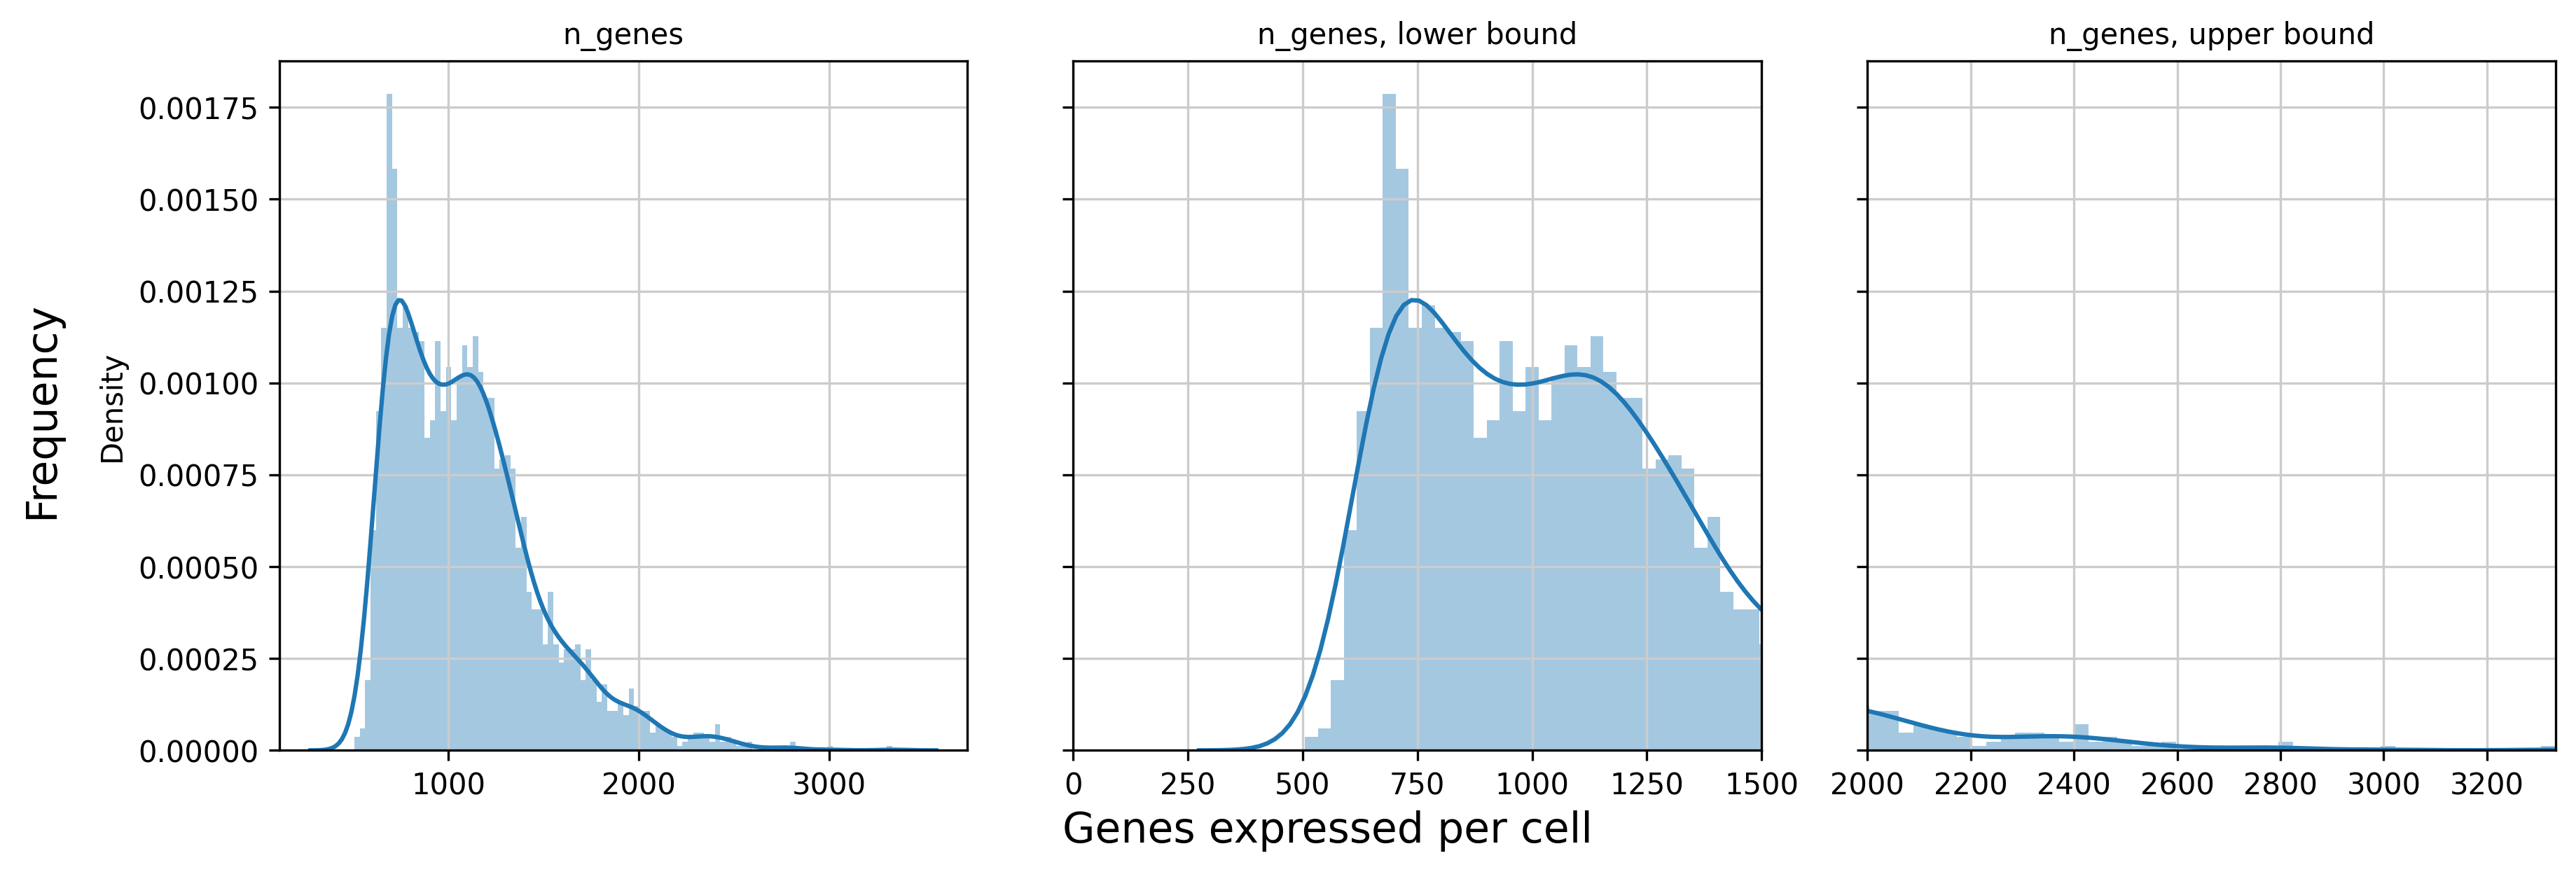

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == "__main__":
/home/mcrewcow/anaconda3/lib/python3.7/site-pa

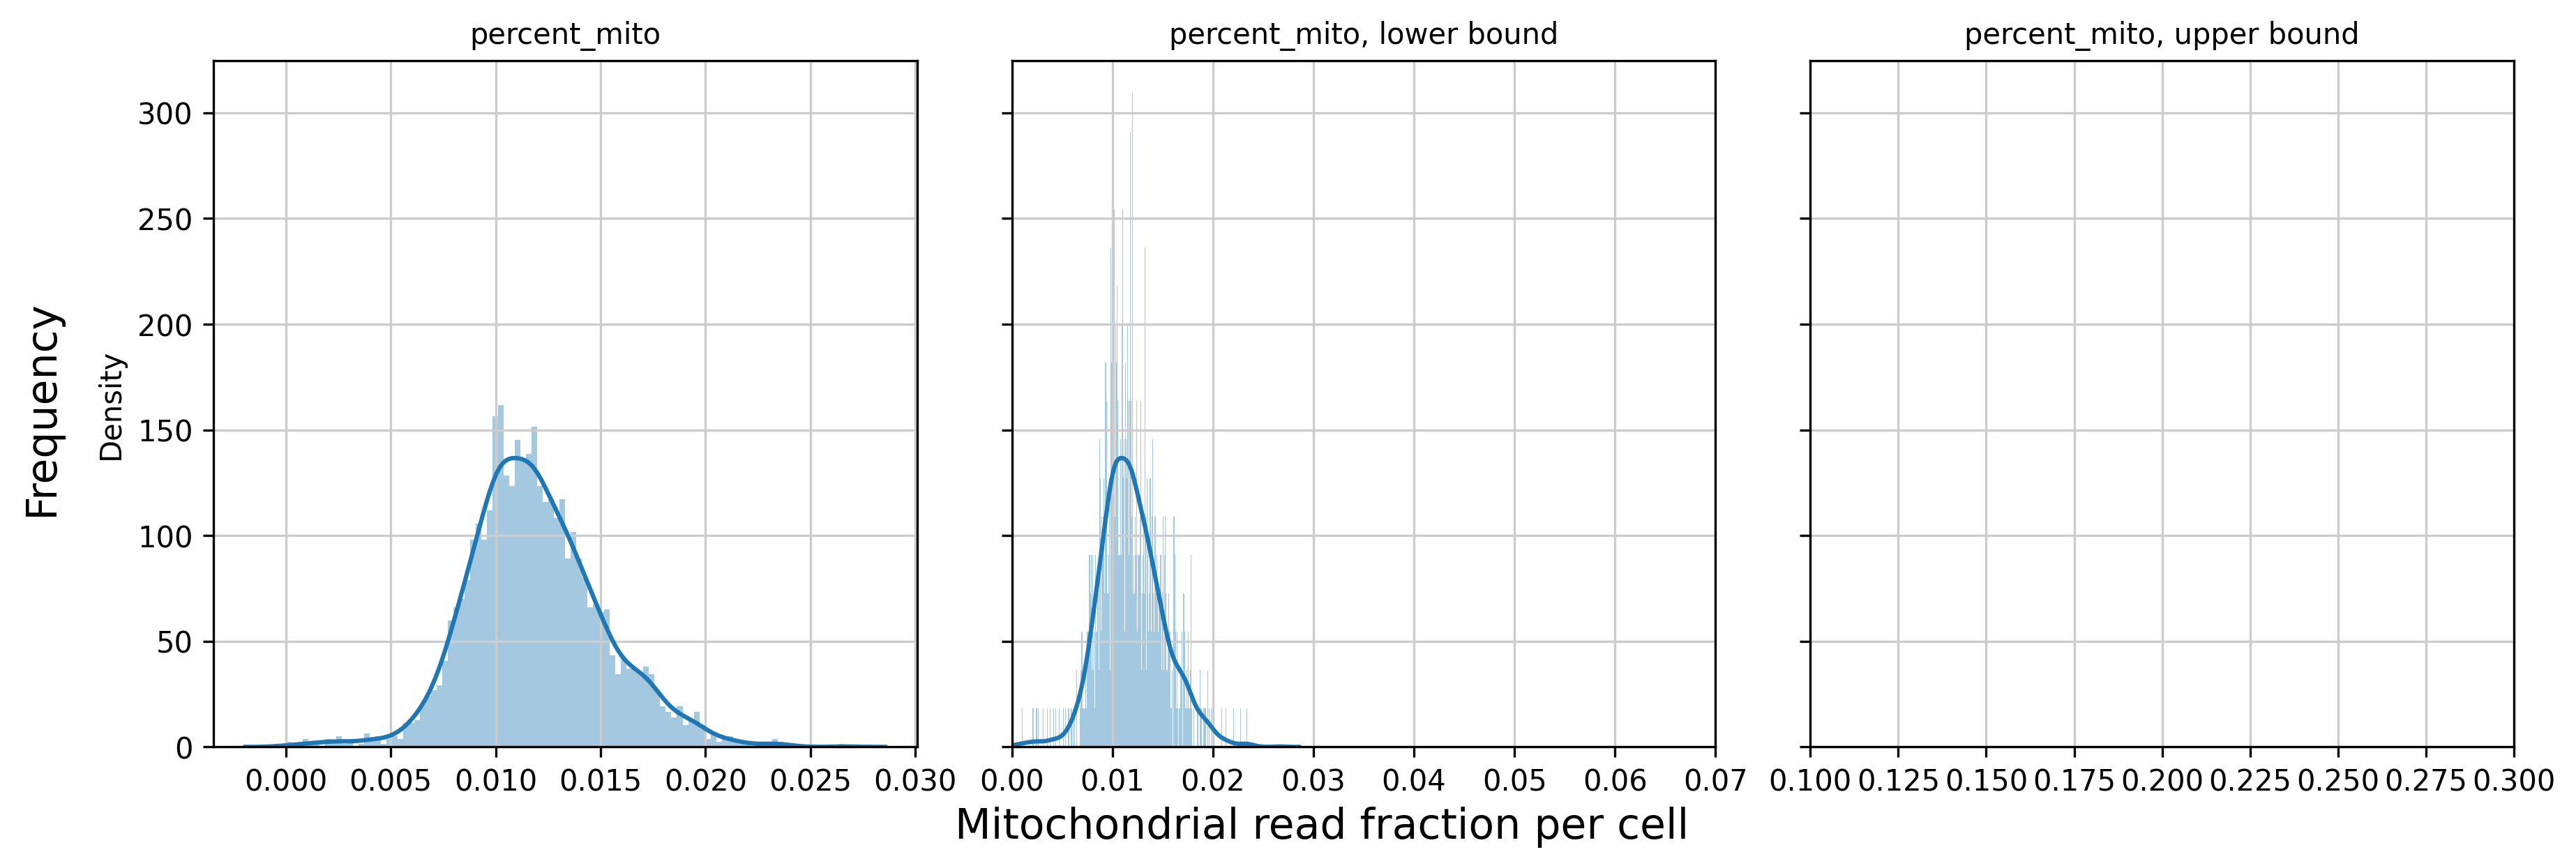

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

In [19]:
adata

AnnData object with n_obs × n_vars = 9773 × 12404
    obs: 'EK_PB_annov1', 'G2M.Score', 'Phase', 'Retina_Cells', 'S.Score', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'origin', 'percent.mt', 'percent.rb', 'timepoint'

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


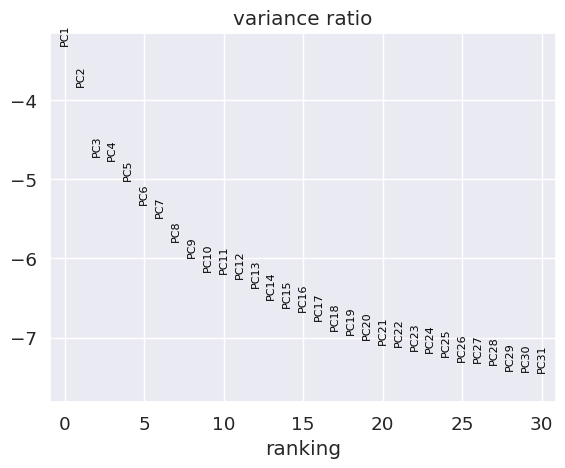

In [80]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

In [81]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)

adata.write( f_anndata_path )

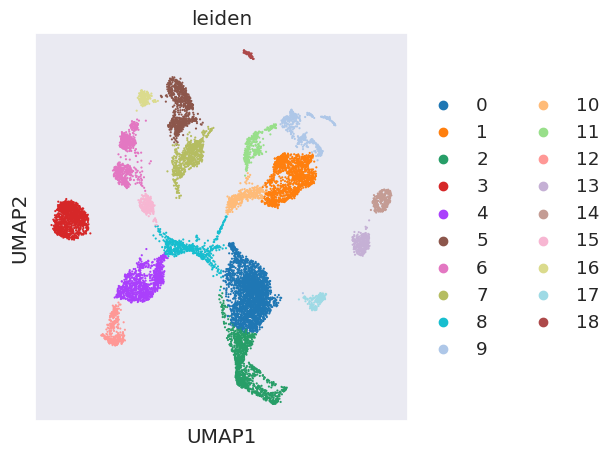

In [82]:
sc.tl.leiden(adata,resolution=0.4)

sc.pl.umap(adata, color=['leiden'] )

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


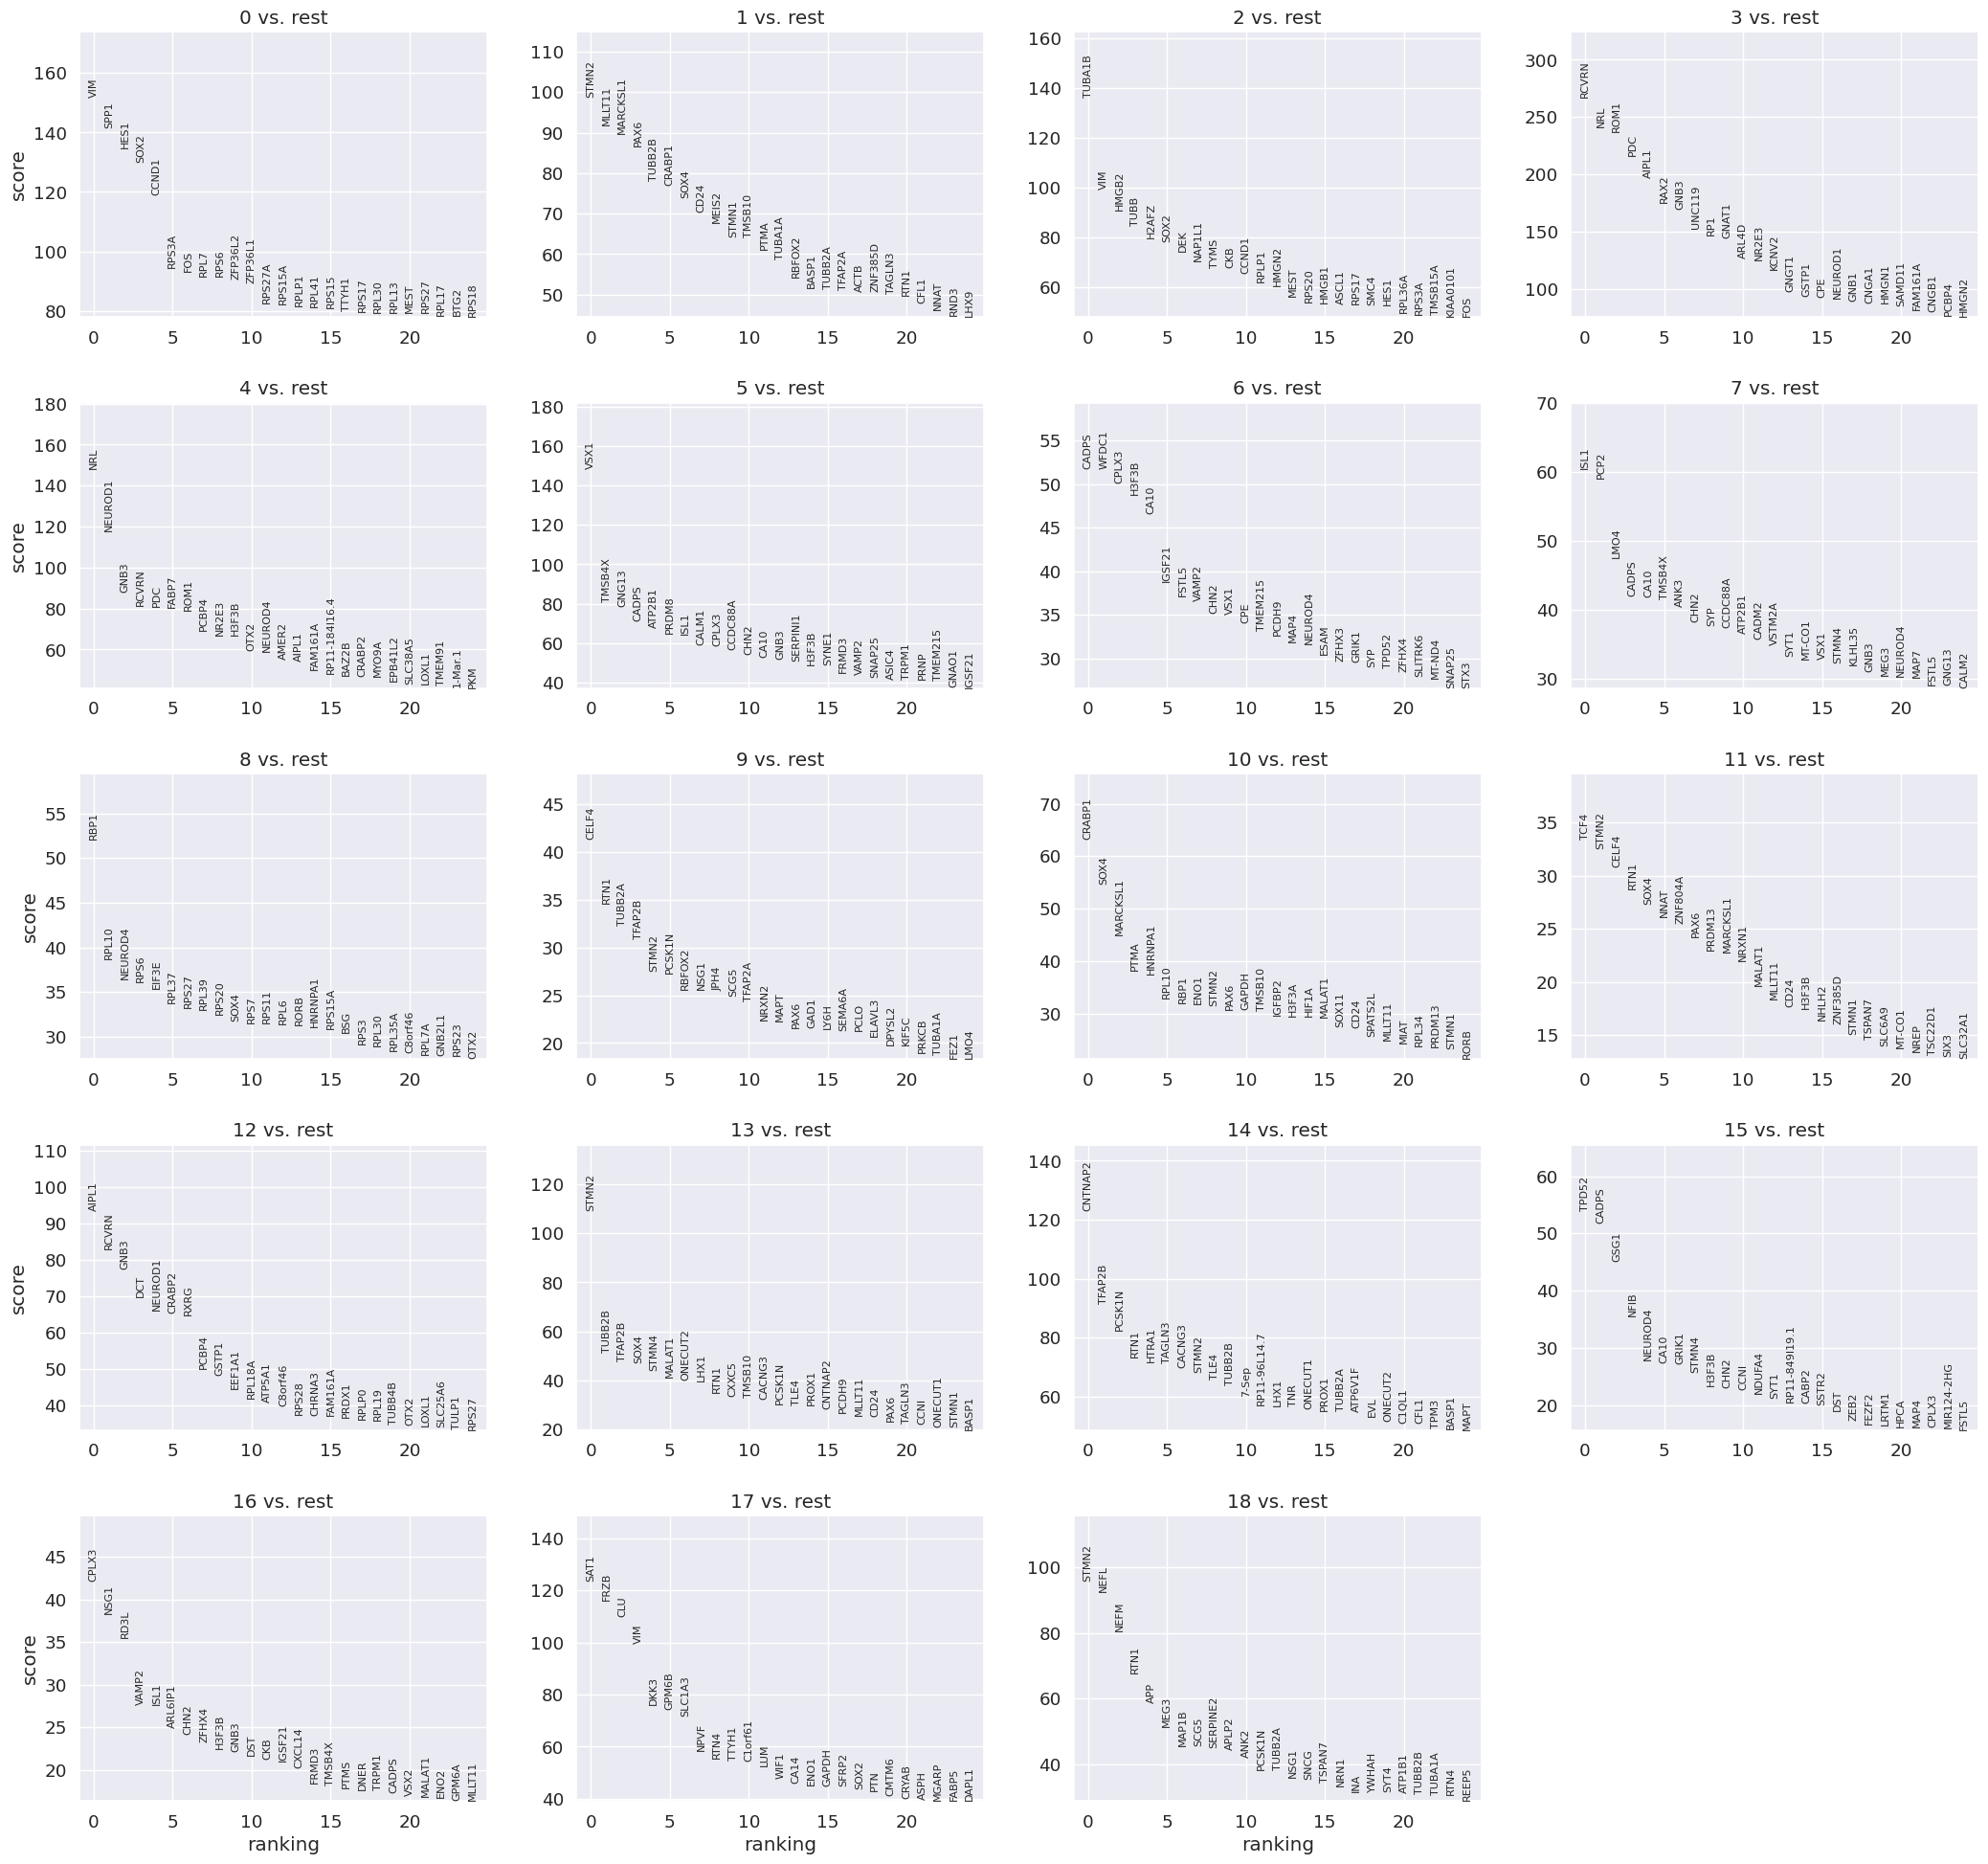

In [83]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [84]:
f_tfs = "/mnt/c/Bioinf/SCENIC_fetal/allTFs_hg38.txt"

In [ ]:
!arboreto_with_multiprocessing.py {f_loom_path_scenic} {f_tfs} --method grnboost2 --output adj_W20.tsv --num_workers 32 --seed 777

Loaded expression matrix of 12367 cells and 13373 genes in 27.8069167137146 seconds...
Loaded 1797 TFs...
starting grnboost2 using 32 processes...
  2%|▉                                    | 327/13373 [10:45<5:48:40,  1.60s/it]

In [ ]:
adjacencies = pd.read_csv("adj_W20.tsv", index_col=False, sep='\t')

In [ ]:
adjacencies.head()

In [ ]:
import glob
# ranking databases
f_db_glob = "/mnt/c/Bioinf/SCENIC_fetal/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/mnt/c/Bioinf/SCENIC_fetal/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj_Day125.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg_W20.csv \
    --mask_dropouts \
    --num_workers 8

In [30]:
adata = sc.read_h5ad('/mnt/c/Bioinf/SCENIC_fetal/anndata_Day125.h5ad' )

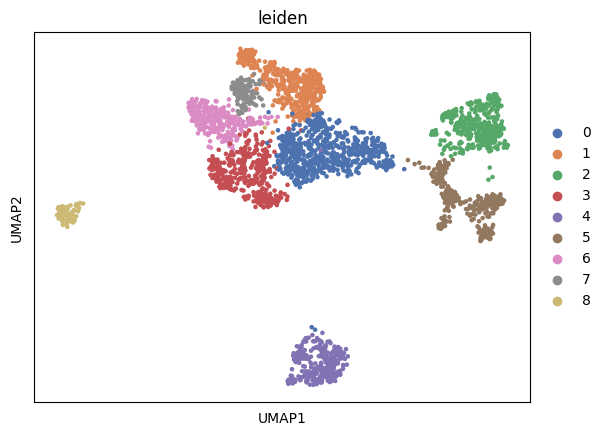

In [11]:
sc.pl.umap(adata, color=['leiden'] )

In [31]:
import numpy as np
import pandas as pd

In [33]:
nGenesDetectedPerCellbefore = np.sum(adata.X>0, axis=1)
a = np.reshape(nGenesDetectedPerCellbefore,9773 )
a = a.A
a = np.reshape(a,9773 )
a = pd.Series(a)
percentiles = a.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

0.01     499.0
0.05     513.0
0.10     533.0
0.50     813.0
1.00    4383.0
dtype: float64


NameError: name 'nGenesDetectedPerCell' is not defined

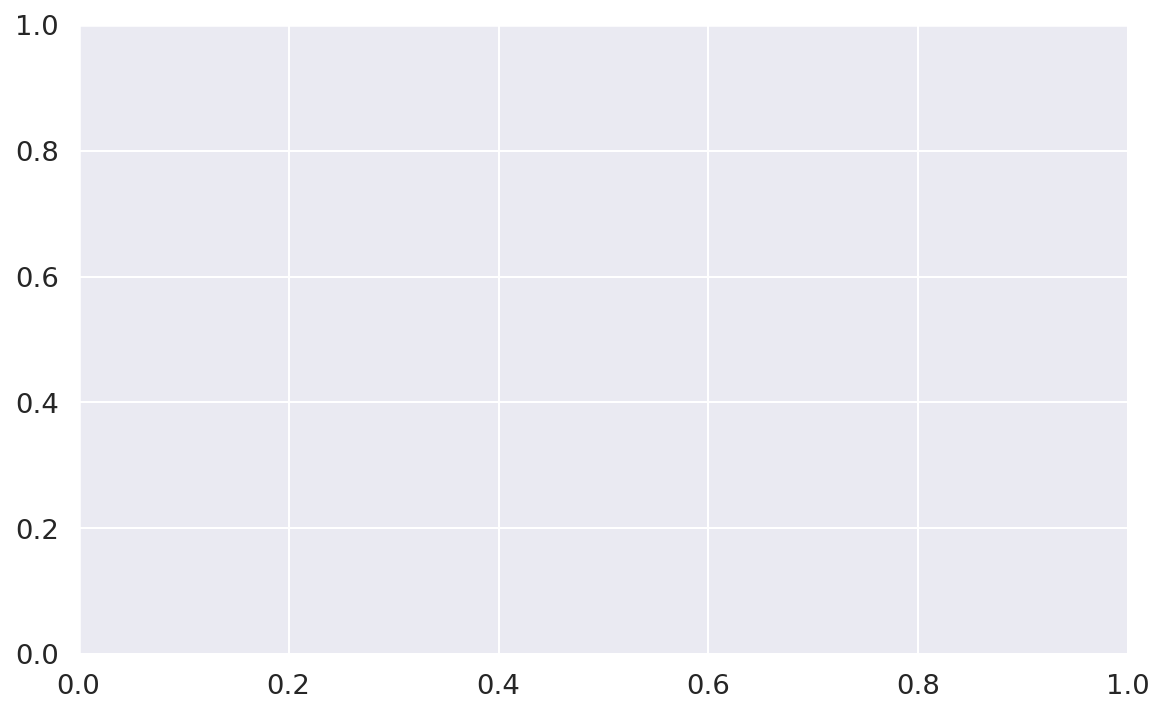

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [34]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg_Day125.csv \
    --output {f_pyscenic_output} \
    --num_workers 8


2024-04-21 23:57:54,815 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-04-21 23:58:17,898 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2024-04-21 23:58:18,275 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2024-04-21 23:58:26,140 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [36]:
lf

In [38]:
lf

In [37]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [39]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap_Day125.txt", sep='\t')

In [40]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap_Day125.txt', sep='\t', header=0, index_col=0 )
###

In [41]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [42]:
Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3']

In [43]:
old_to_new = {
1:'Muller glia',
2:'Rods',
3:'Retinal ganglion cells',
4:'Late (glial) retinal progenitors',
5:'Amacrine cells',
6:'Horizontal cells',
7:'Retinal progenitors',
8:'Bipolar cells',
9:'Cone precursors',
10:'Cones',
11:'Astrocytes',
12:'Microglia'}
adata.obs['EK_PB_annov2'] = (
adata.obs['EK_PB_annov1']
.map(old_to_new).astype('category')
)

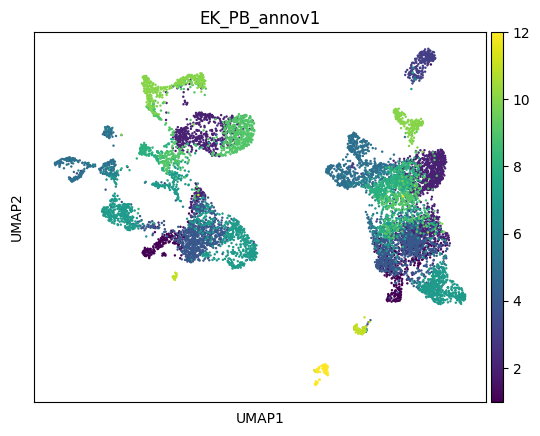

In [44]:
sc.pl.umap(adata, color=['EK_PB_annov1'] )

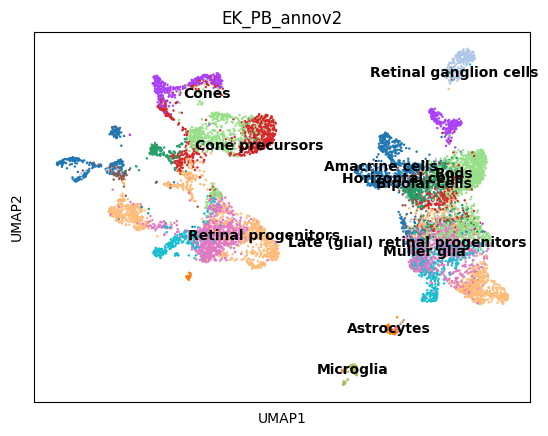

In [45]:
sc.pl.umap(adata, color=['EK_PB_annov2'], legend_loc='on data')

In [46]:
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy leiden default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Leiden_clusters_Scanpy",
        "values": list(set( adata.obs['leiden'].astype(np.str) ))
    },
    {
        "name": "Cell type",
        "values": list(set(adata.obs['EK_PB_annov2'].values))
    },
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['leiden']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['leiden'].values.astype(np.int64)

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [47]:
adata.obs['EK_PB_annov2'].values

['Rods', 'Rods', 'Rods', 'Cones', 'Rods', ..., 'Retinal progenitors', 'Late (glial) retinal progenitors', 'Cones', 'Retinal progenitors', 'Horizontal cells']
Length: 9773
Categories (12, object): ['Amacrine cells', 'Astrocytes', 'Bipolar cells', 'Cone precursors', ..., 'Muller glia', 'Retinal ganglion cells', 'Retinal progenitors', 'Rods']

In [33]:
adata.obs

EK_PB_annov1  G2M.Score Phase  Retina_Cells   S.Score  \
CellID                                                                         
AAACCTGAGTAATCCC-1_16             9  -0.189445    G1             2 -0.176629   
AAACCTGAGTGCTGCC-1_16             2  -0.632186    G1             2 -0.272366   
AAACCTGAGTTACCCA-1_16             1  -0.039592     S             2  0.035549   
AAACCTGCAAACGTGG-1_16             5  -0.193890    G1             2 -0.161756   
AAACCTGCACCACGTG-1_16             7  -0.240545    G1             2 -0.133301   
...                             ...        ...   ...           ...       ...   
TTTGCGCCAGGAATGC-1_18             5  -0.244117    G1             2 -0.194179   
TTTGCGCGTGGTCCGT-1_18             8  -0.106192    G1             2 -0.168571   
TTTGGTTAGACGACGT-1_18             5  -0.147375    G1             2 -0.027322   
TTTGGTTGTCGAACAG-1_18             5  -0.116046    G1             2 -0.078458   
TTTGTCAAGCTATGCT-1_18             7  -0.106376    G1             2 -0.046233   

                       nCount_RNA  nFeature_RNA  nGene          origin  \
CellID                                                                   
AAACCTGAGTAATCCC-1_16      2808.0          1352   1342  Thomas Reh Lab   
AAACCTGAGTGCTGCC-1_16      5784.0          2475   2436  Thomas Reh Lab   
AAACCTGAGTTACCCA-1_16      1556.0           982    974  Thomas Reh Lab   
AAACCTGCAAACGTGG-1_16      2323.0          1306   1293  Thomas Reh Lab   
AAACCTGCACCACGTG-1_16      2244.0          1108   1102  Thomas Reh Lab   
...                           ...           ...    ...             ...   
TTTGCGCCAGGAATGC-1_18      7697.0          2321   2296  Thomas Reh Lab   
TTTGCGCGTGGTCCGT-1_18      3782.0          1644   1630  Thomas Reh Lab   
TTTGGTTAGACGACGT-1_18      3557.0          1914   1882  Thomas Reh Lab   
TTTGGTTGTCGAACAG-1_18      2190.0          1213   1201  Thomas Reh Lab   
TTTGTCAAGCTATGCT-1_18      2444.0          1254   1240  Thomas Reh Lab   

                       percent.mt  percent.rb t_factor timepoint leiden  \
CellID                                                                    
AAACCTGAGTAATCCC-1_16    3.561254   18.269231       NA    Day 80      2   
AAACCTGAGTGCTGCC-1_16    2.887275   24.533195       NA    Day 80      5   
AAACCTGAGTTACCCA-1_16    5.334190   15.102828       NA    Day 80      0   
AAACCTGCAAACGTGG-1_16    2.152389   13.301765       NA    Day 80      6   
AAACCTGCACCACGTG-1_16    3.253119   18.360071       NA    Day 80      8   
...                           ...         ...      ...       ...    ...   
TTTGCGCCAGGAATGC-1_18    4.651163   34.636872       NA    Day 80      1   
TTTGCGCGTGGTCCGT-1_18    3.543099   21.628768       NA    Day 80      3   
TTTGGTTAGACGACGT-1_18    3.486084   10.345797       NA    Day 80      1   
TTTGGTTGTCGAACAG-1_18    3.287671   14.794521       NA    Day 80      1   
TTTGTCAAGCTATGCT-1_18    3.559738   15.875614       NA    Day 80      8   

                              EK_PB_annov2  
CellID                                      
AAACCTGAGTAATCCC-1_16      Cone precursors  
AAACCTGAGTGCTGCC-1_16                 Rods  
AAACCTGAGTTACCCA-1_16          Muller glia  
AAACCTGCAAACGTGG-1_16       Amacrine cells  
AAACCTGCACCACGTG-1_16  Retinal progenitors  
...                                    ...  
TTTGCGCCAGGAATGC-1_18       Amacrine cells  
TTTGCGCGTGGTCCGT-1_18        Bipolar cells  
TTTGGTTAGACGACGT-1_18       Amacrine cells  
TTTGGTTGTCGAACAG-1_18       Amacrine cells  
TTTGTCAAGCTATGCT-1_18  Retinal progenitors  

[9500 rows x 15 columns]

In [48]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [49]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['nCount_RNA'].values),
    "nGene": np.array(adata.obs['nFeature_RNA'].values),
    "Leiden_clusters_Scanpy": np.array( adata.obs['leiden'].values),
    "Celltype": np.array(adata.obs['EK_PB_annov2'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent.mt'].values),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['leiden'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [50]:
lf

In [69]:
np.array(adata.obs['leiden'].values)

array(['1', '3', '0', ..., '0', '5', '3'], dtype=object)

In [50]:
metaJson

{'embeddings': [{'id': 1, 'name': 'Scanpy UMAP  (highly variable genes)'},
  {'id': 2, 'name': 'Scanpy PC1/PC2'},
  {'id': 3, 'name': 'SCENIC AUC t-SNE'},
  {'id': 4, 'name': 'SCENIC AUC UMAP'}],
 'clusterings': [{'id': 0,
   'group': 'Scanpy',
   'name': 'Scanpy leiden default resolution',
   'clusters': [{'id': 0, 'description': 'Unannotated Cluster 1'},
    {'id': 1, 'description': 'Unannotated Cluster 2'},
    {'id': 2, 'description': 'Unannotated Cluster 3'},
    {'id': 3, 'description': 'Unannotated Cluster 4'},
    {'id': 4, 'description': 'Unannotated Cluster 5'},
    {'id': 5, 'description': 'Unannotated Cluster 6'},
    {'id': 6, 'description': 'Unannotated Cluster 7'},
    {'id': 7, 'description': 'Unannotated Cluster 8'}]}],
 'metrics': [{'name': 'nUMI'}, {'name': 'nGene'}, {'name': 'Percent_mito'}],
 'annotations': [{'name': 'Leiden_clusters_Scanpy',
   'values': ['4', '6', '3', '1', '7', '2', '0', '5']},
  {'name': 'Cell type', 'values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

In [51]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs,
    file_attrs=attrs
)
lf.close()

In [52]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [54]:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [55]:
cellAnnot = pd.concat(
    [
        
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Leiden_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Celltype, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI',
'Cell type']

In [56]:
lf.ca

In [57]:
lf

In [58]:
dr = [
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [59]:
lf.close()

In [60]:
from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [61]:
df_motifs = load_motifs('reg_Day125.csv')

In [62]:
selected_motifs = ['PAX6','TCF3','EBF1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [63]:
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

In [64]:
adata

AnnData object with n_obs × n_vars = 9773 × 12404
    obs: 'EK_PB_annov1', 'G2M.Score', 'Phase', 'Retina_Cells', 'S.Score', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'origin', 'percent.mt', 'percent.rb', 'timepoint', 'leiden', 'EK_PB_annov2'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'EK_PB_annov2_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [65]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

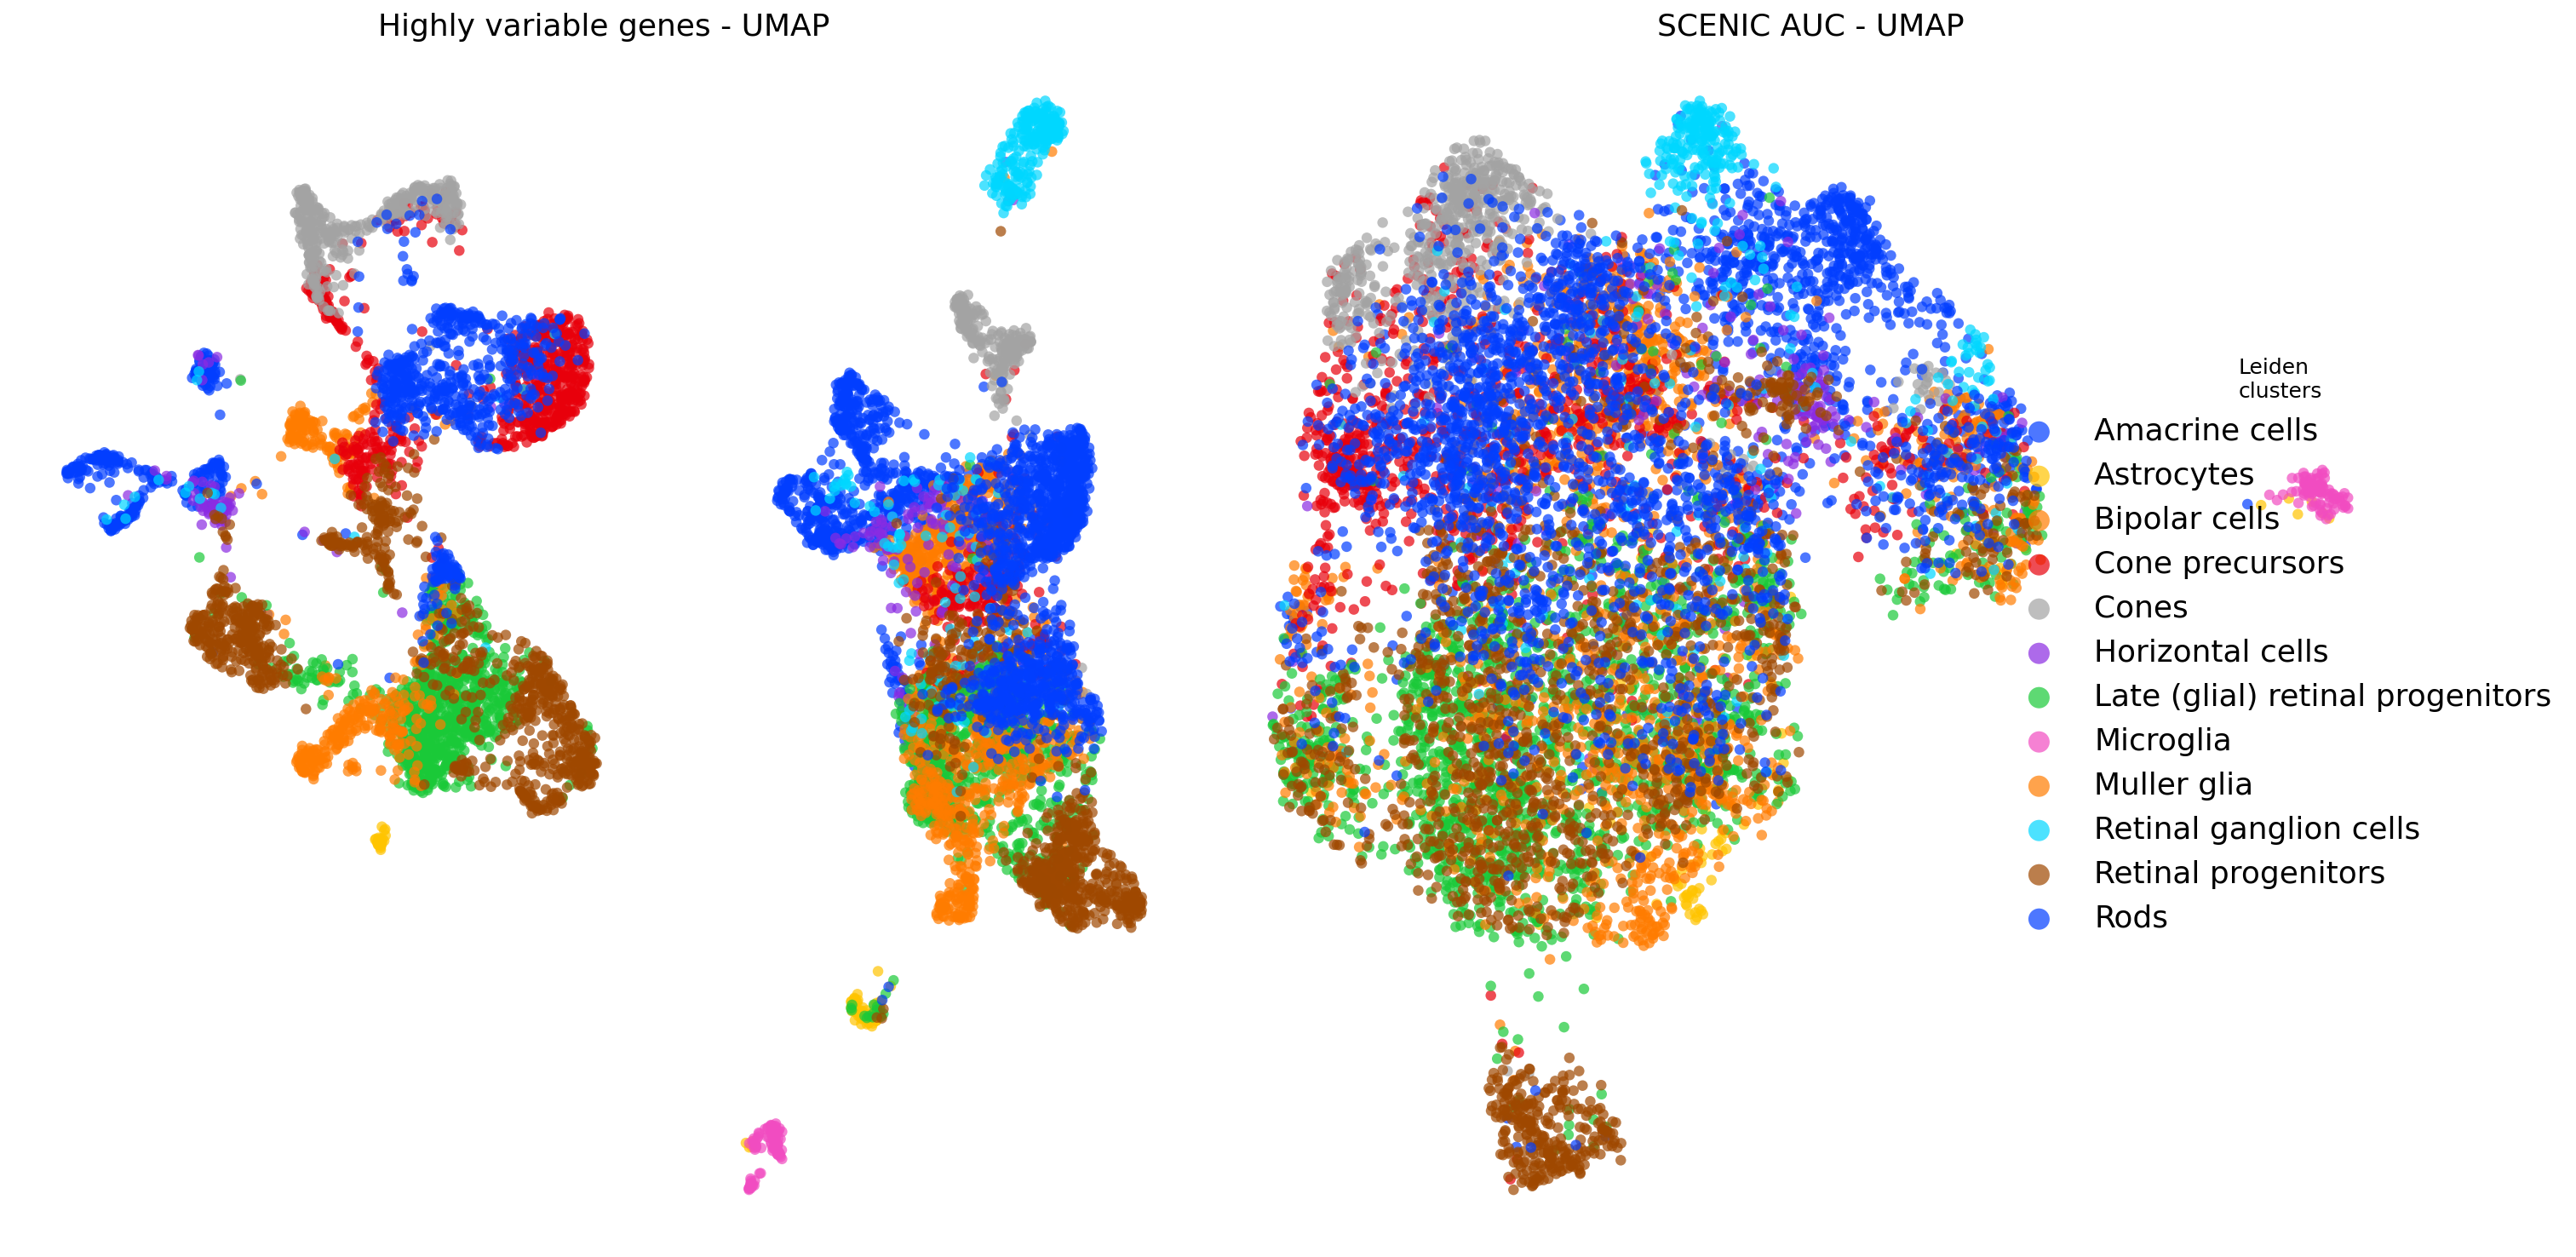

In [66]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Cell type'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[2], colorlab=cellAnnot['Cell type'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Leiden\nclusters")

plt.tight_layout()
plt.savefig("FD125_dimred_umap-hvg-scenic-leiden.pdf", dpi=600, bbox_inches = "tight")

In [67]:
dr

[                               X          Y
 AAACATACACGCTA-1_22    14.414616   7.383288
 AAACATACGAGACG-1_22    12.221192   6.673439
 AAACATTGACCTCC-1_22    13.825224  12.398444
 AAACATTGTCTTCA-1_22    11.492587  15.193355
 AAACCGTGATCGGT-1_22    12.951933   9.406527
 ...                          ...        ...
 TTTGGTTGTTATTCTC-1_23  -1.916403   8.171476
 TTTGGTTTCCATTCAT-1_23  -1.398329   7.175675
 TTTGTTGAGCATCGAG-1_23  -6.084632  17.514357
 TTTGTTGCAAATACGA-1_23   0.983167   6.583476
 TTTGTTGCATGACTGT-1_23  -8.910614  11.515902
 
 [9773 rows x 2 columns],
                                X          Y
 AAACATACACGCTA-1_22    -6.439800  -2.208864
 AAACATACGAGACG-1_22   -12.910574  -2.395033
 AAACATTGACCTCC-1_22    -9.144936   4.108519
 AAACATTGTCTTCA-1_22    -4.138332   4.312644
 AAACCGTGATCGGT-1_22    -8.891308  -0.355437
 ...                          ...        ...
 TTTGGTTGTTATTCTC-1_23  19.988665  -8.527560
 TTTGGTTTCCATTCAT-1_23  19.295311 -10.871758
 TTTGTTGAGCATCGAG-1_23  14.

In [68]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [69]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Cell type'] )
rss_cellType

AHR_(+)    AR_(+)  ARID3A_(+)  ARNTL_(+)  \
Rods                              0.226984  0.260479    0.331353   0.287132   
Cones                             0.195563  0.198964    0.211895   0.197877   
Muller glia                       0.199449  0.232545    0.227516   0.229079   
Retinal ganglion cells            0.203973  0.213885    0.217167   0.197067   
Cone precursors                   0.215930  0.227788    0.283693   0.281663   
Amacrine cells                    0.237673  0.237131    0.308036   0.237544   
Retinal progenitors               0.212159  0.249726    0.266246   0.270558   
Late (glial) retinal progenitors  0.209470  0.244620    0.271181   0.266738   
Bipolar cells                     0.216450  0.225085    0.258653   0.218079   
Astrocytes                        0.182108  0.180643    0.180589   0.177536   
Horizontal cells                  0.190493  0.189302    0.205267   0.195481   
Microglia                         0.267673  0.178447    0.189996   0.176365   

                                  ATF1_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)  \
Rods                              0.247972  0.306817  0.339234  0.362338   
Cones                             0.194420  0.207214  0.237441  0.241630   
Muller glia                       0.206966  0.215521  0.251595  0.249842   
Retinal ganglion cells            0.193675  0.224182  0.211649  0.211558   
Cone precursors                   0.247632  0.233769  0.282850  0.271947   
Amacrine cells                    0.224006  0.235614  0.267587  0.266136   
Retinal progenitors               0.230776  0.224833  0.331127  0.311675   
Late (glial) retinal progenitors  0.231248  0.235564  0.324257  0.316746   
Bipolar cells                     0.214954  0.240103  0.247753  0.254208   
Astrocytes                        0.175580  0.178101  0.183375  0.183268   
Horizontal cells                  0.190609  0.194658  0.197259  0.193879   
Microglia                         0.173452  0.170857  0.183399  0.185007   

                                  ATF6_(+)  ATF6B_(+)  ...  ZNF580_(+)  \
Rods                              0.297662   0.332476  ...    0.334843   
Cones                             0.214071   0.224075  ...    0.240666   
Muller glia                       0.230547   0.257038  ...    0.246559   
Retinal ganglion cells            0.226969   0.229566  ...    0.217703   
Cone precursors                   0.245480   0.264566  ...    0.272708   
Amacrine cells                    0.240394   0.285532  ...    0.302600   
Retinal progenitors               0.306520   0.318665  ...    0.302001   
Late (glial) retinal progenitors  0.299605   0.328744  ...    0.308236   
Bipolar cells                     0.231507   0.256985  ...    0.263101   
Astrocytes                        0.183295   0.183612  ...    0.181809   
Horizontal cells                  0.189114   0.197585  ...    0.200886   
Microglia                         0.170663   0.179436  ...    0.181496   

                                  ZNF613_(+)  ZNF672_(+)  ZNF740_(+)  \
Rods                                0.277513    0.296595    0.220651   
Cones                               0.201189    0.235408    0.182227   
Muller glia                         0.231559    0.227657    0.192946   
Retinal ganglion cells              0.196299    0.213426    0.202539   
Cone precursors                     0.239466    0.255350    0.207581   
Amacrine cells                      0.230170    0.268311    0.218333   
Retinal progenitors                 0.281854    0.274324    0.190834   
Late (glial) retinal progenitors    0.268382    0.282073    0.216447   
Bipolar cells                       0.231662    0.239671    0.204917   
Astrocytes                          0.183613    0.178293    0.175090   
Horizontal cells                    0.185597    0.192864    0.190283   
Microglia                           0.184355    0.175550    0.170088   

                                  ZNF786_(+)  ZNF90_(+)  ZNF93_(+)  \
Rods                                0.231375   0

In [70]:
cellAnnot

ClusterID Louvain_clusters_Scanpy  Percent_mito  nGene  \
AAACATACACGCTA-1_22           0                       0      4.161850   1027   
AAACATACGAGACG-1_22           0                       0      2.075702    516   
AAACATTGACCTCC-1_22           1                       1      1.566364    798   
AAACATTGTCTTCA-1_22          11                      11      4.595669   1306   
AAACCGTGATCGGT-1_22           1                       1      2.085506    640   
...                         ...                     ...           ...    ...   
TTTGGTTGTTATTCTC-1_23         2                       2      2.874162   2715   
TTTGGTTTCCATTCAT-1_23         2                       2      4.433929   2399   
TTTGTTGAGCATCGAG-1_23         5                       5      9.890384   3342   
TTTGTTGCAAATACGA-1_23         2                       2      6.786810   2868   
TTTGTTGCATGACTGT-1_23         9                       9      1.013358   1357   

                          nUMI                         Cell type  
AAACATACACGCTA-1_22     1730.0                              Rods  
AAACATACGAGACG-1_22      819.0                              Rods  
AAACATTGACCTCC-1_22     1213.0                              Rods  
AAACATTGTCTTCA-1_22     2263.0                             Cones  
AAACCGTGATCGGT-1_22      959.0                              Rods  
...                        ...                               ...  
TTTGGTTGTTATTCTC-1_23   6715.0               Retinal progenitors  
TTTGGTTTCCATTCAT-1_23   5706.0  Late (glial) retinal progenitors  
TTTGTTGAGCATCGAG-1_23  12042.0                             Cones  
TTTGTTGCAAATACGA-1_23   7824.0               Retinal progenitors  
TTTGTTGCATGACTGT-1_23   2171.0                  Horizontal cells  

[9773 rows x 6 columns]

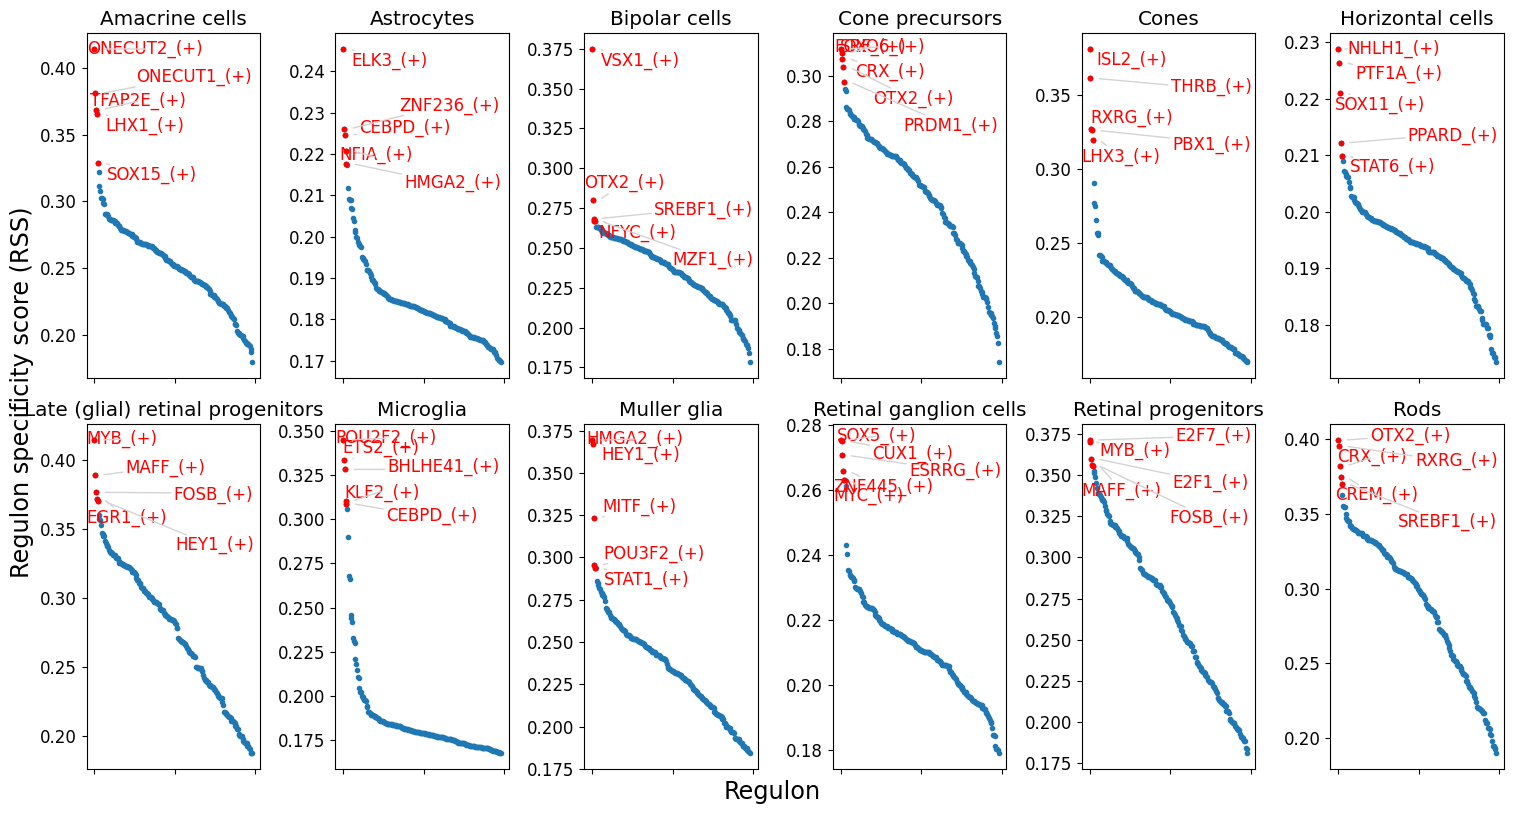

In [71]:
cats = sorted(list(set(cellAnnot['Cell type'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,6,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("FD125_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [72]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [73]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/home/mcrewcow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [75]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Cell type'] ]

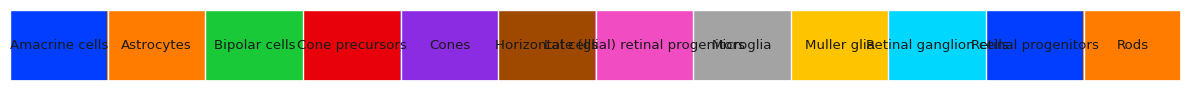

In [76]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("FD125_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

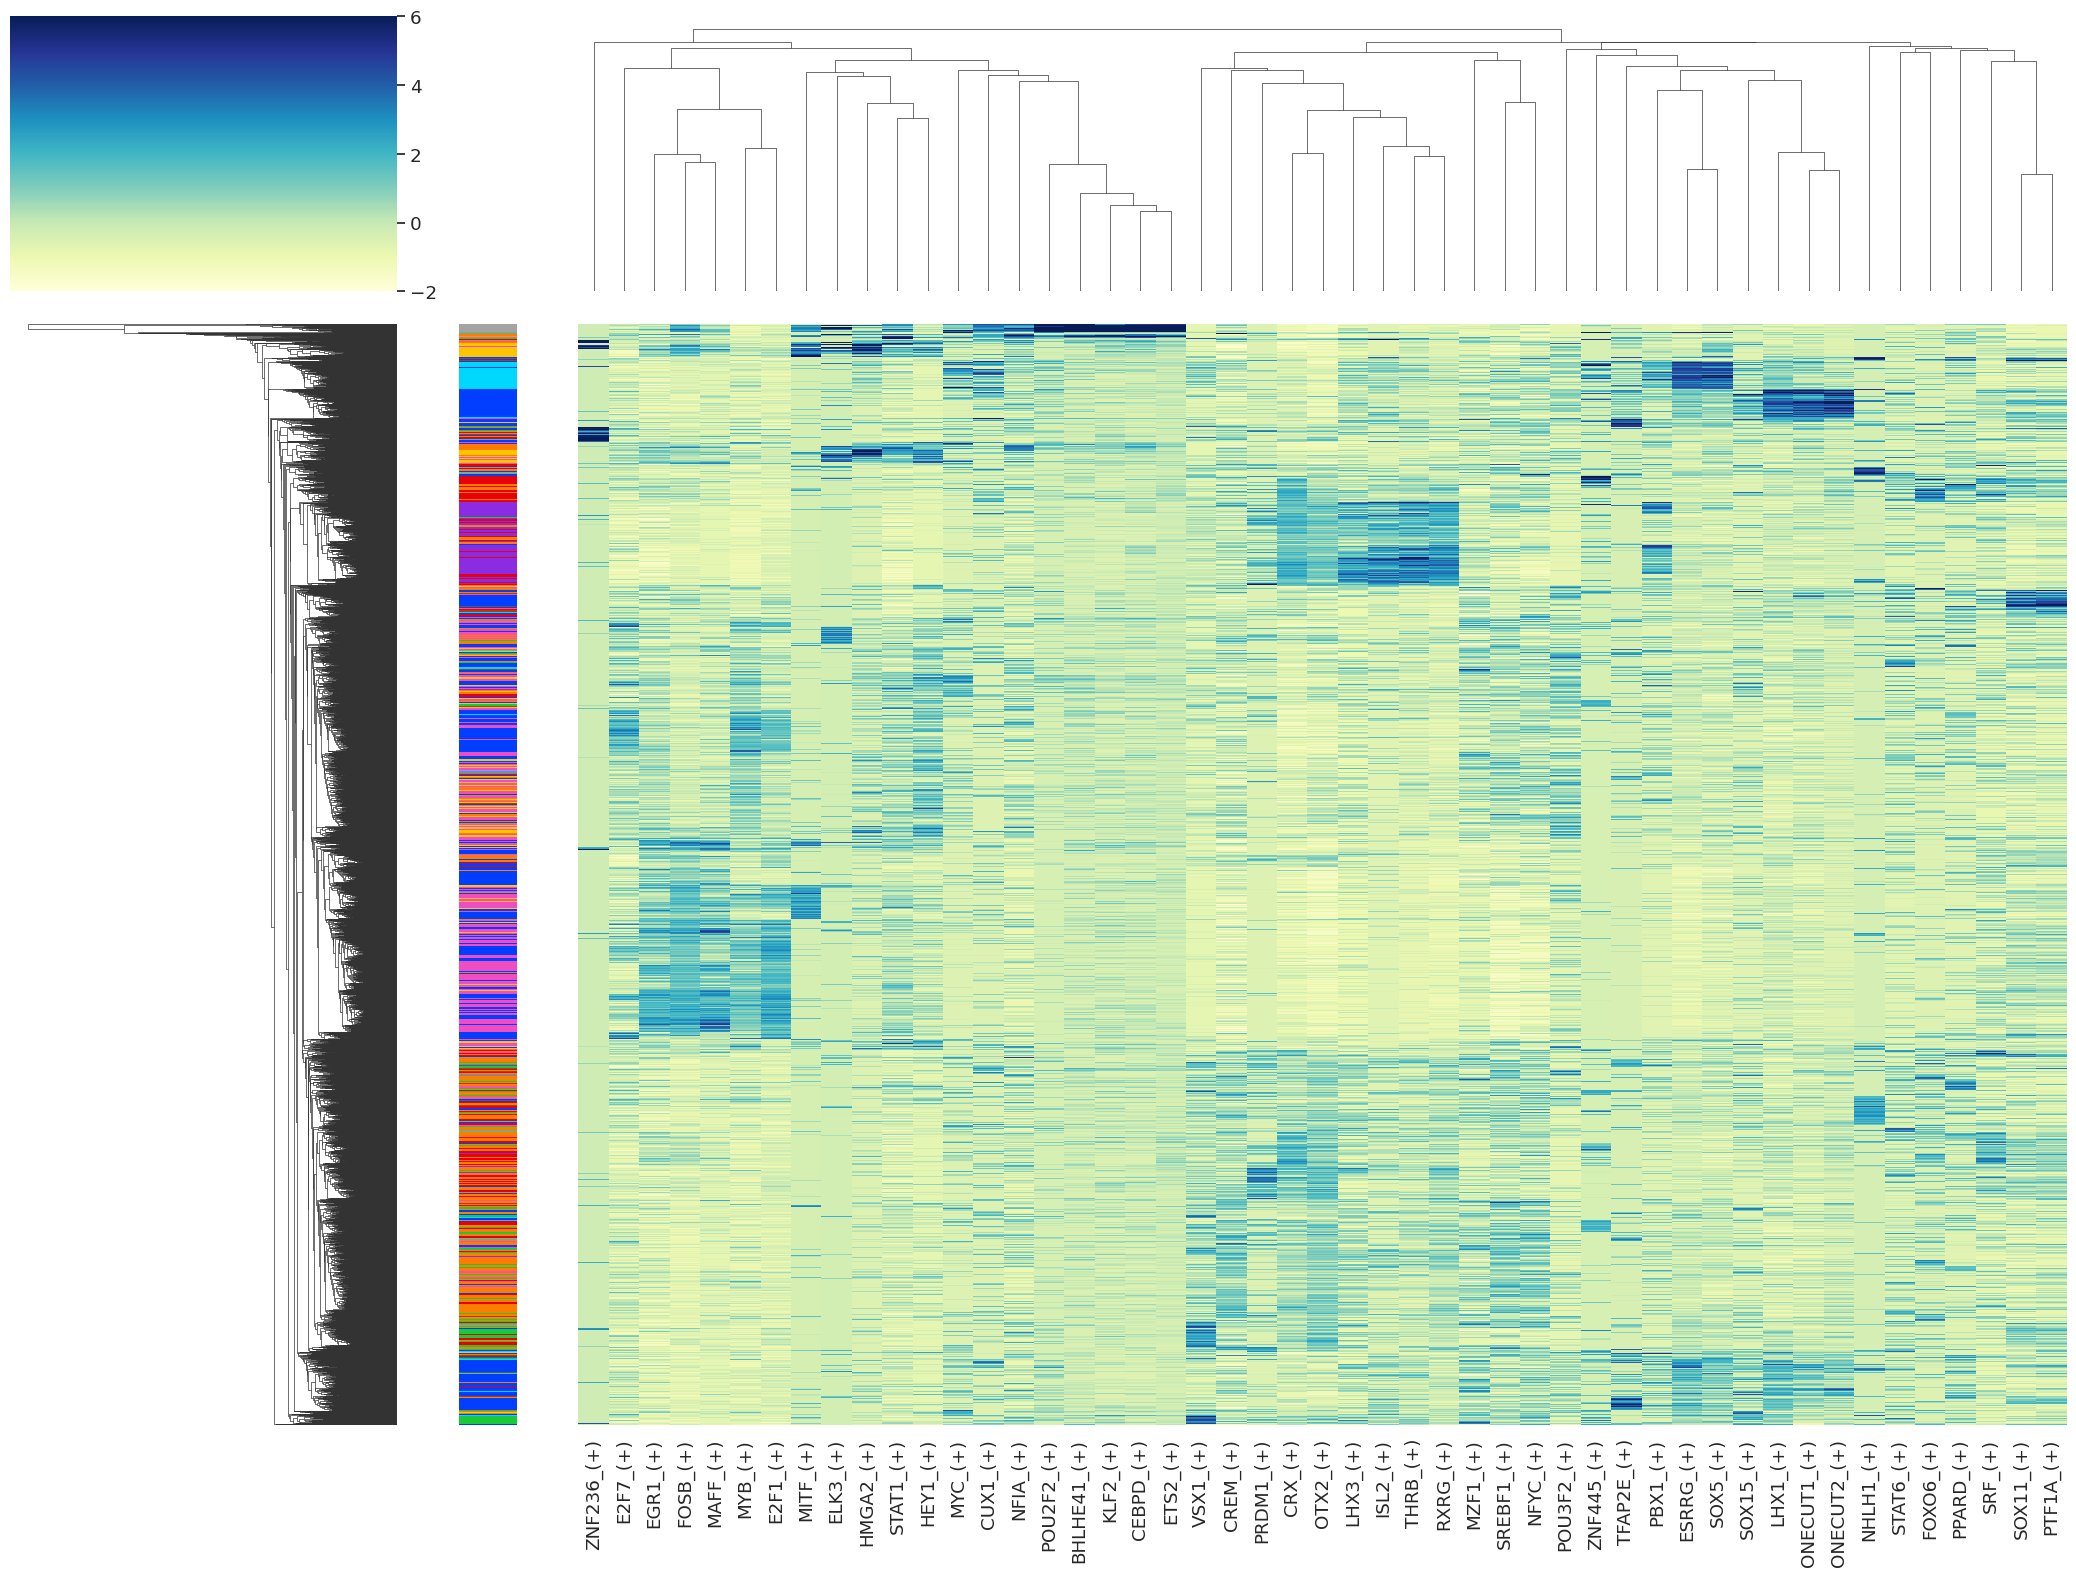

In [77]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("FD125_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [211]:
auc_mtx_Z

AEBP2_(+)  ARID3A_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)  \
AAACATACGAGGCA-1_15  -0.206311   -0.911704 -0.518056 -0.371253  0.978979   
AAACATACTTTCAC-1_15  -0.206311   -0.618149 -0.518056 -1.716093  1.961556   
AAACATTGACCTGA-1_15  -0.206311   -0.203718  0.887292 -0.798520  1.228474   
AAACCGTGAGAACA-1_15  -0.206311    0.329430 -0.518056  0.977089 -0.690478   
AAACCGTGATACCG-1_15  -0.206311   -0.950557 -0.518056 -0.262685 -1.463603   
...                        ...         ...       ...       ...       ...   
TTTGACTGGGGAGT-1_15  -0.206311    3.606025 -0.518056 -0.329227 -1.463603   
TTTGACTGTGGTAC-1_15  -0.206311    0.148117  2.155096 -0.851053  1.206912   
TTTGCATGAATCGC-1_15  -0.206311   -0.706647  0.636124 -0.385262 -1.463603   
TTTGCATGATTGGC-1_15  -0.206311    1.425946 -0.482175  0.942067 -0.641195   
TTTGCATGGGACAG-1_15  -0.206311    0.860420 -0.518056  1.099665  2.195650   

                     ATF6_(+)  BCLAF1_(+)  BPTF_(+)  CEBPB_(+)  CEBPG_(+)  \
AAACATACGAGGCA-1_15  2.221588   -0.612061 -0.830087   0.687542   0.296135   
AAACATACTTTCAC-1_15 -0.715859   -0.103266  0.711497  -0.413890  -1.590631   
AAACATTGACCTGA-1_15  0.366359   -0.157875  0.041045  -0.704189   0.348201   
AAACCGTGAGAACA-1_15 -0.345917   -0.497515 -0.830087   1.081724  -0.184854   
AAACCGTGATACCG-1_15  0.388445   -0.093943 -0.830087  -0.623076   0.821751   
...                       ...         ...       ...        ...        ...   
TTTGACTGGGGAGT-1_15 -1.452061   -0.120581 -0.027368   0.630621  -0.628653   
TTTGACTGTGGTAC-1_15  0.773110    0.453477  0.159628  -0.039630   0.001095   
TTTGCATGAATCGC-1_15 -1.496233    0.019270  0.779910  -0.691382   0.556464   
TTTGCATGATTGGC-1_15  1.647351   -0.990327  2.713731   0.269169   0.137458   
TTTGCATGGGACAG-1_15  0.653477    0.591997 -0.830087   0.089866  -0.296424   

                     ...  ZNF641_(+)  ZNF654_(+)  ZNF699_(+)  ZNF711_(+)  \
AAACATACGAGGCA-1_15  ...    0.558093   -0.527665   -0.285979   -1.069145   
AAACATACTTTCAC-1_15  ...    0.047111   -0.527665   -0.285979   -1.069145   
AAACATTGACCTGA-1_15  ...    0.130423   -0.527665   -0.285979    0.163629   
AAACCGTGAGAACA-1_15  ...   -0.669376   -0.527665    1.117181    0.886180   
AAACCGTGATACCG-1_15  ...    0.585864    1.952656   -0.285979   -0.495541   
...                  ...         ...         ...         ...         ...   
TTTGACTGGGGAGT-1_15  ...   -0.669376   -0.527665   -0.285979   -1.069145   
TTTGACTGTGGTAC-1_15  ...   -0.663822    3.409988   -0.285979   -0.245183   
TTTGCATGAATCGC-1_15  ...    1.307904    0.575335   -0.285979    0.768924   
TTTGCATGATTGGC-1_15  ...   -0.486089   -0.527665   -0.285979    1.012943   
TTTGCATGGGACAG-1_15  ...    4.262716   -0.276204   -0.285979   -0.511386   

                     ZNF740_(+)  ZNF77_(+)  ZNF770_(+)  ZNF837_(+)  \
AAACATACGAGGCA-1_15   -0.357282   1.576603   -0.637110    0.464900   
AAACATACTTTCAC-1_15   -0.357282  -1.753520   -0.039068    1.622817   
AAACATTGACCTGA-1_15   -0.357282   0.937136   -0.637110   -0.523861   
AAACCGTGAGAACA-1_15   -0.357282  -0.002846   -0.637110   -0.380883   
AAACCGTGATACCG-1_15   -0.357282  -0.261429   -0.637110   -0.640659   
...                         ...        ...         ...         ...   
TTTGACTGGGGAGT-1_15    3.582913   0.751935   -0.637110    0.821337   
TTTGACTGTGGTAC-1_15   -0.357282   0.199826    1.584188    1.103265   
TTTGCATGAATCGC-1_15   -0.357282  -0.055262    0.930865    1.413385   
TTTGCATGATTGGC-1_15   -0.357282   1.024495   -0.637110   -0.302346   
TTTGCATGGGACAG-1_15    2.239479   0.842788   -0.637110    0.072215   

                     ZSCAN18_(+)  ZSCAN2_(+)  
AAACATACGAGGCA-1_15    -1.037638   -0.686923  
AAACATACTTTCAC-1_15     0.276333   -0.232285  
AAACATTGACCTGA-1_15     1.117275    0.048590  
AAACCGTGAGAACA-1_15     0.635486   -1.315323  
AAACCGTGATACCG-1_15     1.712942   -0.482217  
...                          ...         ...  
TTTGACTGGGGAGT-1_15    -1.037638   -1.315323  
TTTGACTGTGGTAC-1_15    -0.161657   -0.118031  
TTTGCA

In [212]:
adata.obs

EK_PB_annov1  G2M.Score Phase  Retina_Cells   S.Score  \
CellID                                                                       
AAACATACGAGGCA-1_15             7   0.273759   G2M             2  0.194739   
AAACATACTTTCAC-1_15             3  -0.137892    G1             2 -0.102535   
AAACATTGACCTGA-1_15             3  -0.222697    G1             2 -0.182406   
AAACCGTGAGAACA-1_15             4  -0.190340    G1             2 -0.065979   
AAACCGTGATACCG-1_15             5  -0.118872    G1             2 -0.095025   
...                           ...        ...   ...           ...       ...   
TTTGACTGGGGAGT-1_15             4  -0.114401    G1             2 -0.064985   
TTTGACTGTGGTAC-1_15             3  -0.213258    G1             2 -0.192374   
TTTGCATGAATCGC-1_15             5  -0.130297    G1             2 -0.115540   
TTTGCATGATTGGC-1_15             7   0.931866   G2M             2  0.049279   
TTTGCATGGGACAG-1_15             3  -0.076436    G1             2 -0.060215   

                     nCount_RNA  nFeature_RNA  nGene          origin  \
CellID                                                                 
AAACATACGAGGCA-1_15      1976.0          1042   1031  Thomas Reh Lab   
AAACATACTTTCAC-1_15      1735.0           918    909  Thomas Reh Lab   
AAACATTGACCTGA-1_15      2323.0          1140   1131  Thomas Reh Lab   
AAACCGTGAGAACA-1_15      2751.0          1214   1187  Thomas Reh Lab   
AAACCGTGATACCG-1_15      1360.0           711    701  Thomas Reh Lab   
...                         ...           ...    ...             ...   
TTTGACTGGGGAGT-1_15      1464.0           668    661  Thomas Reh Lab   
TTTGACTGTGGTAC-1_15      2190.0          1104   1094  Thomas Reh Lab   
TTTGCATGAATCGC-1_15      1405.0           730    729  Thomas Reh Lab   
TTTGCATGATTGGC-1_15      1608.0           940    922  Thomas Reh Lab   
TTTGCATGGGACAG-1_15      1328.0           700    690  Thomas Reh Lab   

                     percent.mt  percent.rb timepoint  n_genes  percent_mito  \
CellID                                                                         
AAACATACGAGGCA-1_15    1.012146   27.277328    Day 59     1031      0.008233   
AAACATACTTTCAC-1_15    1.152738   24.034582    Day 59      909      0.008772   
AAACATTGACCTGA-1_15    0.516573   22.987516    Day 59     1131      0.005791   
AAACCGTGAGAACA-1_15    1.999273   29.989095    Day 59     1187      0.011768   
AAACCGTGATACCG-1_15    3.529412   30.147059    Day 59      701      0.018882   
...                         ...         ...       ...      ...           ...   
TTTGACTGGGGAGT-1_15    2.322404   39.959016    Day 59      661      0.014663   
TTTGACTGTGGTAC-1_15    1.826484   21.232877    Day 59     1094      0.012439   
TTTGCATGAATCGC-1_15    0.854093   24.270463    Day 59      729      0.007969   
TTTGCATGATTGGC-1_15    1.865672   22.014925    Day 59      922      0.011961   
TTTGCATGGGACAG-1_15    1.656627   30.120482    Day 59      690      0.012525   

                        n_counts leiden                      EK_PB_annov2  
CellID                                                                     
AAACATACGAGGCA-1_15  2140.482422      1               Retinal progenitors  
AAACATACTTTCAC-1_15  2006.252686      3            Retinal ganglion cells  
AAACATTGACCTGA-1_15  2266.998535      0            Retinal ganglion cells  
AAACCGTGAGAACA-1_15  2223.166016      6  Late (glial) retinal progenitors  
AAACCGTGATACCG-1_15  1703.899902      2                    Amacrine cells  
...                          ...    ...                               ...  
TTTGACTGGGGAGT-1_15  1586.584106      1  Late (glial) retinal progenitors  
TTTGACTGTGGTAC-1_15  2229.561035      0            Retinal ganglion cells  
TTTGCATGAATCGC-1_15  1760.711304      0                    Amacrine cells  
TTTGCATGATTGGC-1_15  2052.047852      5               Retinal progenitors  
TTTGCATGGGACAG-1_15  1696.481201      3            Retinal ganglion cells  

[2950 rows x 17 columns]

In [213]:
auc_mtx_Z['Cell type'] = adata.obs['EK_PB_annov2']

In [214]:
adata.obs['EK_PB_annov2'].values

['Retinal progenitors', 'Retinal ganglion cells', 'Retinal ganglion cells', 'Late (glial) retinal progenitors', 'Amacrine cells', ..., 'Late (glial) retinal progenitors', 'Retinal ganglion cells', 'Amacrine cells', 'Retinal progenitors', 'Retinal ganglion cells']
Length: 2950
Categories (12, object): ['Amacrine cells', 'Astrocytes', 'Bipolar cells', 'Cone precursors', ..., 'Muller glia', 'Retinal ganglion cells', 'Retinal progenitors', 'Rods']

In [215]:
sns.set(font_scale=1.2)

# Assuming 'auc_mtx_Z' has a column named 'Cell type' that you want to sort by
# Create a categorical type for the 'Cell type' column based on an optional custom order
cell_type_order = ['Amacrine cells', 'Astrocytes', 'Bipolar cells', 'Cone precursors', 'Late (glial) retinal progenitors', 'Cones', 'Microglia',
                   'Horizontal cells', 'Muller glia', 'Retinal ganglion cells', 'Retinal progenitors', 'Rods']  # Modify as needed
auc_mtx_Z['Cell type'] = pd.Categorical(auc_mtx_Z['Cell type'], categories=cell_type_order, ordered=True)

# Sort the DataFrame by 'Cell type'
auc_mtx_Z.sort_values('Cell type', inplace=True)

# Use the sorted DataFrame for the clustermap
g = sns.clustermap(auc_mtx_Z[topreg], annot=False, square=False, linecolor='gray',
                   yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
                   cmap="YlGnBu", figsize=(21, 16))

# Make colorbar visible
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

Text(0.5, -533.4833333333324, '')